In [470]:
import mido
from matplotlib import pyplot as plt
import numpy as np
import os
from math import sqrt

np.set_printoptions(suppress=True)

In [471]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
# os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [472]:
import sys  

sys.path.insert(0, '/raid/shumnov/music-style-performer/src/ml/discriminator')

In [473]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

# Discriminator

In [474]:
from model import OCCModel
from autoencoder import MLPAutoencoder
from data_preprocessing import *

In [475]:
architecture = [((256, 128), (0, 0), (128, 256), (0, 0)), 
                ((256, 128, 128), (0.1, 0.1, 0.1), (128, 128, 256), (0.1, 0.1, 0.1)), 
                ((256, 256, 128), (0.4, 0.2, 0.1), (128, 256, 256), (0.1, 0.1, 0.1)),
                ((128, 64, 64), (0, 0, 0), (64, 64, 128), (0, 0, 0))]
noise = [0.02, 0.08, 0.2]
latent_dim = [64, 32]
absolute_velocities = [True, False]

In [476]:
config = (1, 0, 2, 3)

arch = architecture[config[3]]
n = noise[config[2]]
ld = latent_dim[config[0]]
av = absolute_velocities[config[1]]

In [477]:
dp = DataProcessor(
    notes_qty=64, 
    include_first_tone=False, 
    absolute_velocities=av)

dset = Dataset(dp, 32)
dset.load_dset(PROJECT_PATH + 'data/dset64.npy', 2000)
# dp.loadparams('normparams_64_0000.txt')

In [478]:
# dp.saveparams('normparams_64_0000.txt')

In [479]:
autoencoder = MLPAutoencoder(
    input_size=dp.input_size,
    latent_dim=ld,
    noise=n,
    encoder_layers=arch[0],
    encoder_dropout=arch[1],
    decoder_layers=arch[2],
    decoder_dropout=arch[3])

In [481]:
model = OCCModel(autoencoder, dp, 1, 1, 1)

model.load(PROJECT_PATH+f'traindata/ae/64/1023_leg4/checkpoints/ckpt-39')

# PCA

In [482]:
encoded = autoencoder.encoder(dset.train)

In [483]:
# @tf.function
def pca(data, k):
    mean = tf.reduce_mean(data, axis=0)
    centered_data = data - mean
    covariance_matrix = tf.matmul(tf.transpose(centered_data), centered_data) / tf.cast(tf.shape(centered_data)[0], tf.float32)

    # Step 4: Perform eigenvalue decomposition
    eigenvalues, eigenvectors = tf.linalg.eigh(covariance_matrix)

    # Step 5: Select top-k eigenvectors
    top_k_eigenvectors = eigenvectors[:, -k:]

    return top_k_eigenvectors, mean


# @tf.function
def pca_project(data, principals, mean):
    centered_data = data - mean
    projected_data = tf.matmul(centered_data, principals) # + m
    
    return projected_data # + mean

# Data

In [484]:
def Note(tone, time, duration, velocity, dist):
    return [tone, time, duration, velocity, dist]

In [485]:
def track2line(track, ticks_per_beat):
    line = []

    time = 0
    for m in track:
        time += m.time / ticks_per_beat / 2

        if m.type == 'note_on' and m.velocity > 0:
            if len(line) > 0:
                line[-1][4] = time - line[-1][1]
            line.append(Note(m.note, time, -1, m.velocity, -1))
            
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            i = 1
            while line[-i][0] != m.note:
                i += 1
            
            line[-i][2] = time - line[-i][1]
    
    if len(line) > 0:
        line[-1][4] = line[-1][2]
            
    return line

In [486]:
def graph_line(line, yi=0):
    x = np.cumsum(line[..., 1])
    y = line[..., yi]
    
    plt.plot(x, y, 'o-')
    plt.show()

In [487]:
mid1 = mido.MidiFile(PROJECT_PATH + 'test/satie.mid')
mid2 = mido.MidiFile(PROJECT_PATH + 'test/sibelius_clean.mid')

In [488]:
from numpy.lib.stride_tricks import sliding_window_view

def preprocess(mid):
    line = track2line(mid.tracks[0], mid.ticks_per_beat)
    line = np.array(line)

    line[..., 1] = line[..., 4]
    vels = line[..., 3].copy()
    line[..., 3] = line[..., 2] / line[..., 1]
    line[..., 2] = vels
    line = np.delete(line, 4, axis=-1)
    
    tones = line[..., 0].copy()
    
    line = np.squeeze(sliding_window_view(line, (dp.notes_qty, 4))).copy()
    dset, fnotes = dp.make_relative(line)
    dset, fnotes = dp.normalize(dset, fnotes, False)
    
    fnotes = np.concatenate([np.zeros(shape=(fnotes.shape[0], 1)), fnotes], axis=-1)
    
    return np.concatenate([np.expand_dims(fnotes, axis=1), dset], axis=1), tones


def reshape(line):
    line = np.reshape(line, [line.shape[0], line.shape[1] * line.shape[2]])
    if not dp.include_first_tone:
        line = line[:, 1:]
        
    return line

In [489]:
line1, tones1 = preprocess(mid1)[:] # satie
line2, tones2 = preprocess(mid2)[:] # sibelius

print(line1.shape, line2.shape)

line3 = line1.copy()
line3[..., 2] = np.random.normal(0, 1)

line4 = line2.copy()
line4[..., 2] = np.random.normal(0, 1)

(17, 64, 4) (494, 64, 4)


In [490]:
en1 = autoencoder.encoder(reshape(line1))
en2 = autoencoder.encoder(reshape(line2))
en3 = autoencoder.encoder(reshape(line3))
en4 = autoencoder.encoder(reshape(line4))

In [491]:
PCADIM=64

In [492]:
principals, mean = pca(encoded, PCADIM)

In [500]:
print(dp.normparams)
print(principals.shape, mean)

for i in range(principals.shape[0]):
    for j in range(principals.shape[1]):
        print(float(principals[i, j]), end=' ')
    print('\n')

(0.002967872, 4.5980473, 5.0, 69.19582, 17.084038, 69.19582, 17.084038)
(32, 32) tf.Tensor(
[-0.09225152 -0.00891281 -0.4017885  -0.0453759   0.02857463  0.09277705
 -0.02508214 -0.03472485 -0.24709895 -0.06372     0.01442546  0.0009972
  0.01562816  0.03359781 -0.00978789 -0.00416338  0.0147238   0.02222952
 -0.02509911  0.03549658 -0.00692005 -0.08966849  0.08146419  0.00217576
  0.01693071  0.00454647  0.02730766  0.0226735   0.0219153   0.17888123
  0.04920038  0.02469144], shape=(32,), dtype=float32)
-0.25977960228919983 -0.030558299273252487 -0.008019695058465004 0.02931470237672329 0.12662824988365173 0.008594143204391003 0.07447317242622375 0.02471313066780567 0.09718058258295059 0.03939438238739967 0.10046423226594925 -0.09061327576637268 0.12954731285572052 -0.0009637427283450961 0.09047400206327438 -0.5138884782791138 0.15460553765296936 0.30437055230140686 -0.08096478879451752 0.301785409450531 0.06256495416164398 0.08082004636526108 -0.09797599166631699 0.14635895192623138

-0.017148306593298912 -0.23668912053108215 5.311152199283242e-05 -0.10818572342395782 -0.12253177911043167 -0.26197192072868347 0.015390969812870026 0.42692744731903076 0.024311475455760956 0.12761083245277405 -0.15318581461906433 -0.1108643189072609 -0.17406924068927765 0.04834843426942825 0.29614099860191345 0.23266267776489258 -0.20155741274356842 0.026900753378868103 -0.06459618359804153 -0.15082190930843353 0.028871865943074226 0.2633846402168274 0.06598362326622009 0.06603199988603592 0.09831433743238449 0.19644249975681305 -0.2894830107688904 -0.29838281869888306 0.07069002836942673 0.029777096584439278 -0.24604007601737976 0.06352820992469788 

-0.08030186593532562 0.118000827729702 -0.19539563357830048 0.06526851654052734 0.29769623279571533 -0.12706179916858673 -0.03237574175000191 -0.0339772067964077 -0.02551938407123089 0.040311120450496674 0.015094481408596039 -0.3267316222190857 0.04098443686962128 0.15572288632392883 0.12641248106956482 -0.06842918694019318 0.08424299955

0.5369341373443604 0.03978053107857704 -0.14061976969242096 0.11725327372550964 -0.06238570436835289 -0.08660804480314255 0.12926048040390015 -0.02860088273882866 0.3299162685871124 -0.313133180141449 0.1513511687517166 0.23413652181625366 0.11778596043586731 -0.25590917468070984 0.2850167453289032 0.04993845149874687 -0.05462198704481125 0.0666380450129509 0.06614767760038376 0.06542771309614182 -0.1588839292526245 0.06842502951622009 -0.13104532659053802 0.15518075227737427 -0.050159867852926254 0.042193666100502014 -0.023100653663277626 0.13092023134231567 0.28106287121772766 0.059216126799583435 -0.09012521803379059 0.010296094231307507 

0.13231147825717926 0.11914338171482086 0.15792535245418549 -0.07760515809059143 -0.006802916526794434 -0.012378156185150146 -0.14973828196525574 0.10294511169195175 0.09077808260917664 0.23077240586280823 -0.5461726784706116 -0.08123262971639633 0.37318697571754456 0.046787746250629425 -0.018084265291690826 -0.03256382793188095 -0.16478331387043 

In [435]:
pca1 = pca_project(en1, principals, mean)
pca2 = pca_project(en2, principals, mean)
pca3 = pca_project(en3, principals, mean)
pca4 = pca_project(en4, principals, mean)

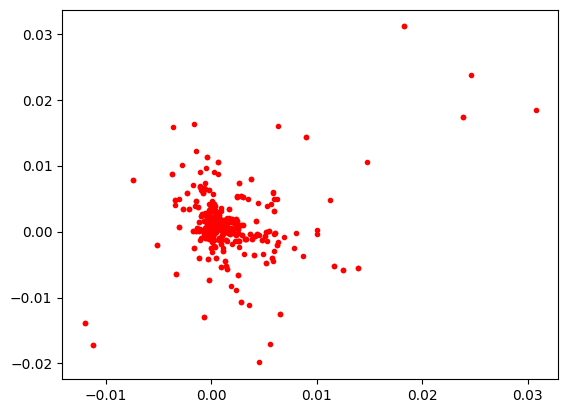

In [436]:
for i in range(len(pca1)):
    plt.plot(pca1[i][0], pca1[i][1], 'b.', label='satie')
    
for i in range(len(pca2)):
    plt.plot(pca2[i][0], pca2[i][1], 'r.', label='sibelius')

# plt.legend()
plt.show()

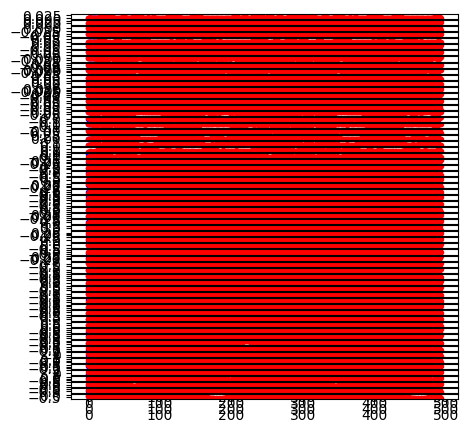

In [437]:
fig, axs = plt.subplots(PCADIM, figsize=(5, 5))

for i in range(PCADIM):
    axs[i].plot(pca1[..., i], 'b.-', label='satie')
    # axs[i].plot(en1[..., i], 'r.-', label='satie')
    axs[i].plot(pca2[..., i], 'r.-', label='sibelius')

# plt.legend()
plt.show()

# Styling

In [452]:
style = reshape(line1[:1])
style_en = autoencoder.encoder(style)
style_pca = pca_project(style_en, principals, mean)

base = line2[:1][..., :2]
base_tones = tones2[:dp.notes_qty]

In [453]:
dtstart = np.random.normal(-1, 0.01, (1, dp.notes_qty, 1))
velstart = np.random.normal(0, 1, (1, dp.notes_qty, 1))
legstart = np.random.normal(0, 1, (1, dp.notes_qty, 1))

dt = tf.Variable(dtstart, dtype=tf.float32) # constraint=lambda t: tf.clip_by_value(t, DTMIN, DTMAX))
vel = tf.Variable(velstart, dtype=tf.float32)
leg = tf.Variable(legstart, dtype=tf.float32)

In [454]:
DT_MAX = 0.01

def dt_norm(dt):
    return -1 * DT_MAX * (1 / (1 + tf.math.exp(-dt + 6))) / dp.normparams[2]

def dt_additive(dt):
    dt = tf.concat([dt_norm(dt), tf.constant(0, shape=(1,1,1), dtype=tf.float32)], axis=1)
    return tf.experimental.numpy.diff(dt, axis=1)

In [455]:
@tf.function
def process(dt, vel, leg):
    dt = dt_additive(dt)
    
    data = tf.concat([base[..., :1], base[..., 1:2] + dt, vel, leg], axis=-1)
    data = tf.reshape(data, [1, data.shape[1] * data.shape[2]])
    if not dp.include_first_tone:
        data = data[:, 1:]
    
    return data


def reconstruct(base, dt, vel, leg):
    dist = (base[..., 1:2] + dt_additive(dt)) * dp.normparams[2]
    vel = vel * dp.normparams[4] + dp.normparams[3]
    leg = leg + 1
    
    return tf.reshape(dist, shape=(dp.notes_qty)), \
            tf.reshape(vel, shape=(dp.notes_qty)), \
            tf.reshape(leg, shape=(dp.notes_qty))

In [456]:
model.predict(process(dt, vel, leg))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9148171], dtype=float32)>

In [457]:
A = 10
B = 0
C = 1

In [458]:
@tf.function()
def style_loss(encoded): 
    predicted_pca = pca_project(encoded, principals, mean)
    
    loss = tf.reduce_mean(tf.math.square(predicted_pca - style_pca))
    
    return loss

@tf.function()
def content_loss(predicted):
    return tf.constant(0, dtype=tf.float32)

@tf.function()
def quality_loss(predicted, decoded):
    loss = model.predict(predicted, decoded)[0]
    
    return loss

@tf.function()
def overall_loss(dt, vel, leg):
    predicted = process(dt, vel, leg)
    
    encoded = autoencoder.encoder(predicted)
    decoded = autoencoder.decoder(encoded)
    
    lstyle = style_loss(encoded)
    lcontent = content_loss(predicted)
    lquality = quality_loss(predicted, decoded)
    
    ltotal = A * lstyle + B * lcontent + C * lquality 
    
    return ltotal, lstyle, lcontent, lquality

In [459]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [460]:
@tf.function()
def train_step(dt, vel, leg):    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(vel)
        tape.watch(leg)
        tape.watch(dt)
        ltotal, lstyle, lcontent, lquality = overall_loss(dt, vel, leg)

    gdt = tape.gradient(ltotal, dt)
    gvel = tape.gradient(ltotal, vel)
    gleg = tape.gradient(ltotal, leg)
    
    opt.apply_gradients([(gvel, vel), (gleg, leg), (gdt, dt)])
    
    return ltotal, lstyle, lcontent, lquality

In [461]:
def graph(line, value):
    x = np.cumsum(line[0, :, 1])
    y = value 

    plt.plot(x, y, 'o-')
    plt.show()

In [463]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 1000

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        ltotal, lstyle, lcontent, lquality = train_step(dt, vel, leg)
    print(f"Step: {step} | total: {ltotal}, style: {lstyle}, content: {lcontent}, quality: {lquality}")

end = time.time()
print("Total time: {:.1f}".format(end-start))

Step: 1000 | total: 0.6254267692565918, style: 0.039469409734010696, content: 0.0, quality: 0.23073267936706543
Step: 2000 | total: 0.4645934998989105, style: 0.03560643643140793, content: 0.0, quality: 0.10852912068367004
Step: 3000 | total: 0.4285539984703064, style: 0.03348774090409279, content: 0.0, quality: 0.0936766043305397
Step: 4000 | total: 0.423629492521286, style: 0.033126410096883774, content: 0.0, quality: 0.09236538410186768
Step: 5000 | total: 0.42310139536857605, style: 0.033179767429828644, content: 0.0, quality: 0.09130372852087021
Step: 6000 | total: 0.4229983985424042, style: 0.03326208144426346, content: 0.0, quality: 0.09037759155035019
Step: 7000 | total: 0.4229885935783386, style: 0.033296406269073486, content: 0.0, quality: 0.09002452343702316
Step: 8000 | total: 0.4229859709739685, style: 0.03330481797456741, content: 0.0, quality: 0.08993780612945557
Step: 9000 | total: 0.4229747951030731, style: 0.03330282121896744, content: 0.0, quality: 0.0899466052651405

In [464]:
rec_dist, rec_vel, rec_leg = reconstruct(base, dt, vel, leg)

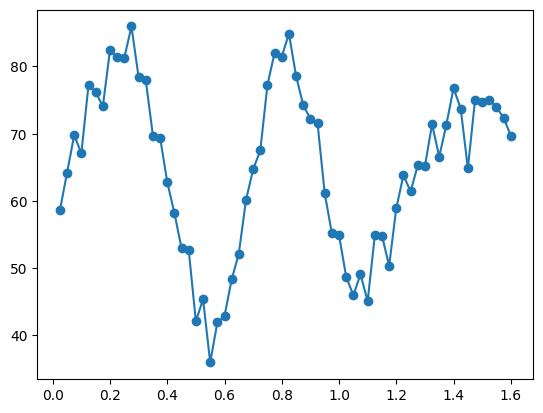

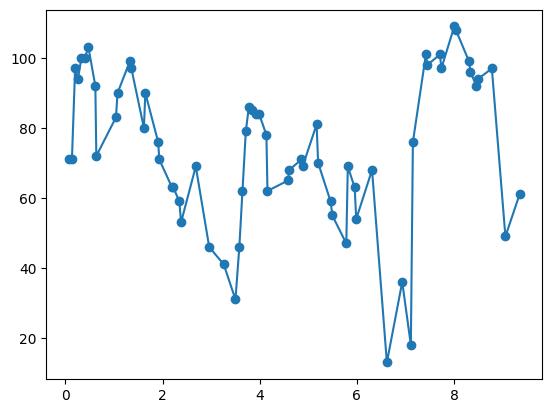

In [465]:
graph(line2, rec_vel)
graph(line1, tf.reshape(line1[0, ..., 2] * dp.normparams[4] + dp.normparams[3], shape=64))

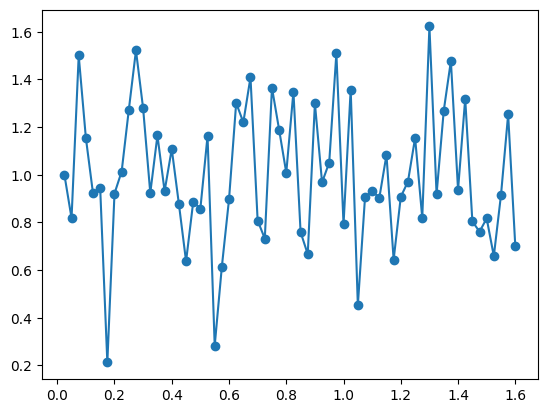

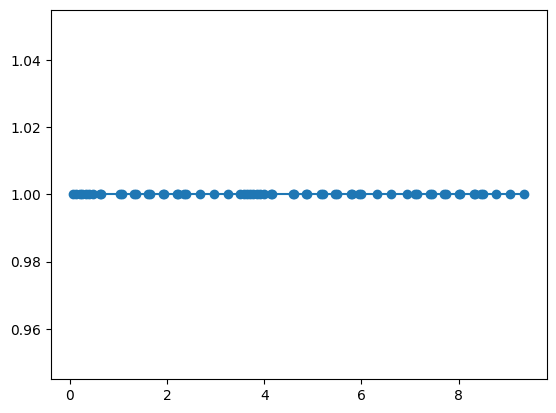

In [466]:
graph(line2, rec_leg)
graph(line1, tf.reshape(line1[0, ..., 3] + 1, shape=64))

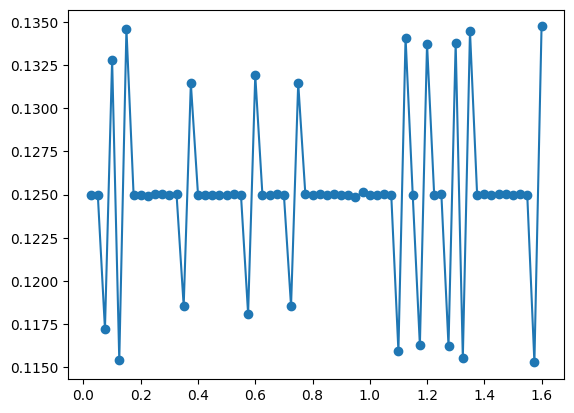

In [467]:
graph(line2, rec_dist)

In [469]:
events = []
time = 0

for i in range(dp.notes_qty):
    diff = int(rec_dist[i] * mid2.ticks_per_beat * 2)
    
    events.append([time, int(base_tones[i]), int(rec_vel[i]), 'note_on'])
    events.append([time + int(diff * rec_leg[i]), int(base_tones[i]), 0, 'note_off'])
    time += diff
    
events.sort(key=lambda e: e[0])
    
mid = mido.MidiFile(type=0)
mid.ticks_per_beat = mid1.ticks_per_beat
track = mido.MidiTrack()
mid.tracks.append(track)

track.append(mido.Message(events[0][3], note=events[0][1], velocity=events[0][2], time=events[0][0]))
prev = 0

for e in events[1:]:
    diff = e[0] - prev
    prev = e[0]
    
    track.append(mido.Message(e[3], note=e[1], velocity=e[2], time=diff))
    
mid.save(PROJECT_PATH + 'test/out/0023_sibelius_satie.mid')